## CODE: Target Function

### Points to note
| Variable          | Functionality                                                   | Remarks                      |
|-------------------|-----------------------------------------------------------------|------------------------------|
| degree            | It changes the degree of Fourier series for the target function | In the Figure 2 it's denoted by $r$ |
| scale_target      | It scales the spectrum of encoding gate for target model        |                              |
| scale_train_model | It scales the spectrum of encoding gate for trainable model     |                              |




| Note          | Remarks                                                   
|-------------------|-----------------------------------------------------------------|
| The target function            | A black colored line plot with black circles embedded on the line|
| The randomly generated trainable model | A blue colored line plot     |
| The trained/optimised model | A colored line plot. Any color except blue     |

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


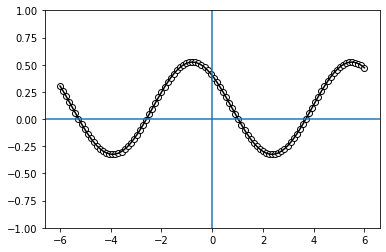

In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

data_points = 100  # number of datas
degree = 1  # degree of the target function

def target_function(x, degree):

    coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
    coeff_0 = 0.1  # coefficient of zero frequency
    scale_target = 1.  # scale_target of the data

    res = 0.0 + 0.0j
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128((idx+1) * 1j * scale_target * x)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res + coeff_0)

x = np.linspace(-6, 6, data_points, requires_grad=False)
target_y = np.array([target_function(x_, degree) for x_ in x], requires_grad=False)

plt.plot(x, target_y, color='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()


My first code block went smooth! The import and variable declaration is fine and all, yet there might be a small detail asking for a sharp attention. It's the fifth variable ```scale_target``` declared to $1$. If this is anything but $1$ then the loss is huge and the trainable model all of the sudden becomes untrainable. This is what authors precisely meant is the account between the expressivity and the data encoding strategy. 

Better yet, define a ```scale_train``` and set it to $1$. Now as long as the difference between ```scale_target``` and ```scale_train_model``` remains $0$ the model is trainable otherwise if not.

The second row of the FIG. 3. is the ouput for  ```scale_target = 1``` and ```scale_train_model = 2```. I have coded for such case in following section 1.2.

Finally, let's make a trainable model to train it!

### Trainable model randomly instantiated

In [3]:
scale_train_model = 1
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def quantum_model(weights, x):

    for (idx, theta) in enumerate(weights):

        ''' This is trainable circuit block. theta_tensor is the tensor containing the weights. The value of weights adjusts to approach the target function as close as possible. The updates happen batchwise. 
        
        The Rot method in qml is the general rotation operator which takes in three parameters theta, phi and a phase. '''
        qml.Rot(theta[0], theta[1], theta[2], wires=0)

        ''' This is encoding gate. It's a roation gate, if x = pi then this is a pauli X-gate '''
        if (idx == len(weights) -1):
            continue
        
        qml.RX(scale_train_model*x, wires=0)

    return qml.expval(qml.PauliZ(wires=0))


The 'weights' is a tensor. In this single-qubit case, it a $1\times3$ row matrix. In a n-qubit model it's $n\times3$ matrix. The three sticks around because 'Rot' method in the class 'qml' takes in exact three parameters. Moreover, the quantum model returns an expectation value for the Pauli Z-gate. Since Hadamard gate is never applied throught the entire model the Pauli Z-gate has no effect like that of an Identity operator/matrix. Well almost! Except for an additional phase of $\pi$ when operated on the state/qubit $|1>. 

$$\sigma_z|1> = e^{i\pi}|1>$$ 

Yet, this difference won't impact the measurement since the phase term is cancelled out by its conjugate during the measurement operation. So, for all the intend of measurement Pauli Z-gate has no effect! As simple as:

$$
<1|\sigma_z^{\dagger}\sigma_z|1> = <1|e^{-i\pi}e^{i\pi}|1>
$$
$$
\therefore <1|\sigma_z^{\dagger}\sigma_z|1> = <1|1> 
$$

I must mention there're nice places to play with qubits [8] [9]. The websites provide a visual and dataful experience. 

In the next code snippet, I have built a random trainable model. After it's visualized it's time to begin the long awaited training!

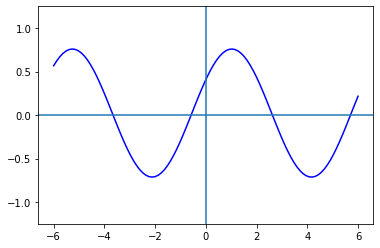

In [4]:
# number of times the encoding gets repeated (here equal to the number of layers)
r = 1

# some random initial weights
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True)

x = np.linspace(-6, 6, data_points, requires_grad=False)
random_quantum_model_y = [quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, color='blue')
plt.ylim(-1.25, 1.25)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()


In [5]:
print(qml.draw(quantum_model)(weights, x[-1]))

 0: ──Rot(2.35, 5.97, 4.6)──RX(6)──Rot(3.76, 0.98, 0.98)──┤ ⟨Z⟩ 



## 1. Replication of FIG. 3.

From the article, the FIG. 3, is extracted and placed below.

<figure>
<img src="assets/images/FIG3.png" alt="Training of different models with different scales" width="325"/>
<figcaption><b>Figure 1 - Training of different models with different scales</b></figcaption>
</figure>

The figure caption is quoted below.

>FIG. 3. A parametrised quantum model is trained with data samples (white circles) to ﬁt a target function g(x) = ′ ∑ n=−1 1 c n e −nix or g (x) = ∑ n=−2 2 c n e −nix with coeﬃcients c 0 = 0.1, c 1 = c 2 = 0.15 − 0.15i. The variational circuit is of the form f(x) = 〈 0 | U † (x)σ z U(x) | 0 〉 where | 0 〉 is a single qubit, and U = W (2) R x (x)W (1) . The W (round blue symbols) are implemented as general rotation gates parametrised by three learnable weights each, and Rx  (square blue symbols) is a single Pauli-X rotation. The left panels show the quantum model function f(x) and target function g(x), g ′ (x), while the right panels show the mean squared error between the data sampled from g and f during a typical training run. Feeding in the input x as is (top row), the quantum model easily ﬁts the target of degree 1. Rescaling the inputs x → 2x causes a frequency mismatch, and the model cannot learn the target any more (middle row). However, even with the correct scaling, the variational circuit cannot ﬁt the target function of degree 2 (bottom row). The experiments in this paper were all performed using the PennyLane software library [36].

## 1.1 The first row
To obtain this result, the scale for target and training model must be $1$. In the code snippet below they are the variables ```scale_target = 1``` and ```scale_train_model = 1```.

The degree of truncated Fourier series in $1$. There's one qubit in the model, so, the number of encoding gate is $1$ too. 

### 1.1.1 Optimization/Learning for the parameteric circuit

In [6]:
def cost(weights, x, y):
    predictions = [quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

cost_ = [cost(weights, x, target_y)]

def optimizer_func(weights):
    # max_steps = 150
    # opt = qml.AdamOptimizer(stepsize=0.25)
    # batch_size = 30

    max_steps = 120
    opt = qml.AdamOptimizer(stepsize=0.4)
    batch_size = 40


    for step in range(max_steps):

        batch_index = np.random.randint(0, len(x), (batch_size,))
        x_batch = x[batch_index]
        y_batch = target_y[batch_index]

        # Update the weights by one optimizer step
        weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

        # Save, and possibly print, the current cost
        c = cost(weights, x, target_y)
        cost_.append(c)
        
        if (step + 1) % 15 == 0:
            print("Cost at step {0:3}: {1}".format(step + 1, c))
    
    return (weights, cost_)

(weights_scale_1_1, cost_1_1 )= optimizer_func(weights)

Cost at step  15: 0.0722666231955169
Cost at step  30: 0.011944659602031369
Cost at step  45: 0.0008478812775901242
Cost at step  60: 0.0009749460834098915
Cost at step  75: 0.00012814578078917135
Cost at step  90: 3.678618857270698e-05
Cost at step 105: 1.664770666812511e-05
Cost at step 120: 5.637304497008881e-07


### 1.1.2 Result
The Loss profile for the training and the graph with both traget model and trained model plotted together is placed below.

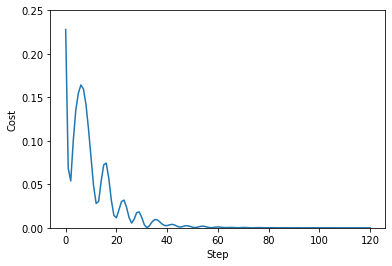

In [7]:
plt.plot(range(len(cost_1_1)), cost_1_1)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()

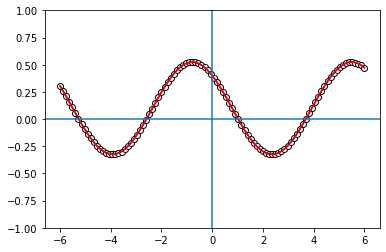

In [8]:
predictions = [quantum_model(weights_scale_1_1, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='red')
plt.ylim(-1,1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

### 1.1.3 Conclusion
When the variables ```scale_target = 1``` and ```scale_train_model = 1```, in other words, the scale is identica then the parametric variational model learns with very minimum loss. The quantum model is trainable!

## 1.2 The second row - Change of scale! 
The above result was for scale_target = 1. and scale_train_model = 1. To obtain the second row figure from the FIG. 3 from the paper set the scale_train_model = 2

Finally, trigger the optimizer!

### 1.2.1 Optimization/Learning for the parameteric circuit

In [9]:
scale_train_model = 2

# Reinitialize the (seeded) random initial weights
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True)
cost_ = [cost(weights, x, target_y)]

#  Run the optimizer for scale_target = 1 and scale_train_model = 2
(weights_scale_1_2, cost_1_2)= optimizer_func(weights)

Cost at step  15: 0.09542347605236906
Cost at step  30: 0.06831038772178118
Cost at step  45: 0.052006645759923004
Cost at step  60: 0.04787771789091735
Cost at step  75: 0.04515621242201365
Cost at step  90: 0.04914696748837678
Cost at step 105: 0.05338856198069949
Cost at step 120: 0.045558859563352316


### 1.2.2 Result

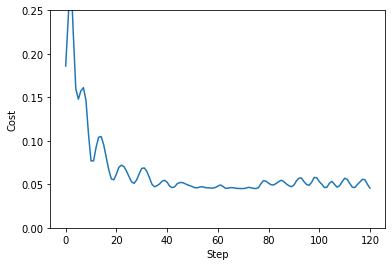

In [10]:
plt.plot(range(len(cost_1_2)), cost_1_2)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()

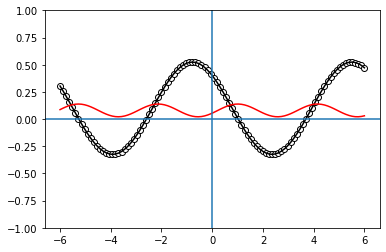

In [11]:
predictions = [quantum_model(weights_scale_1_2, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='red')
plt.ylim(-1,1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

### 1.2.3 Conclusion
When the variables ```scale_target = 1``` and ```scale_train_model = 2```, in other words, the scale is different then the parametric variational model doesn't learn. The loss does not minimise. The quantum model is untrainable!

## 1.3 The third row - Change the degree of the Fourier series to 2 and no difference in scale between the trainable model and the target model.

```scale_target = 1.``` and ```scale_train_model = 1.``` To obtain the third row figure from the FIG. 3 from the paper set the ```degree = 2```.

Finally, trigger the optimizer!


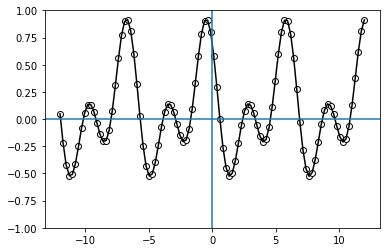

In [12]:
degree = 2

x = np.linspace(-6*degree, 6*degree, data_points, requires_grad=False)
target_y = np.array([target_function(x_, degree) for x_ in x], requires_grad=False)

plt.plot(x, target_y, color='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

### 1.3.1 Optimization/Learning for the parameteric circuit

In [13]:
scale_train_model = 1

# Reinitialize the (seeded) random initial weights
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True)
cost_ = [cost(weights, x, target_y)]

#  Run the optimizer for scale_target = 1 and scale_train_model = 2
(weights_scale_1_3, cost_1_3)= optimizer_func(weights)

Cost at step  15: 0.06535137050511156
Cost at step  30: 0.05368598705922631
Cost at step  45: 0.04769011188688005
Cost at step  60: 0.04879199500721183
Cost at step  75: 0.045332820122448395
Cost at step  90: 0.0562430805997559
Cost at step 105: 0.04632581464547507
Cost at step 120: 0.04746396006390508


### 1.3.2 Result

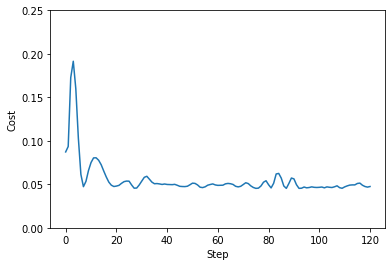

In [14]:
plt.plot(range(len(cost_1_3)), cost_1_3)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()

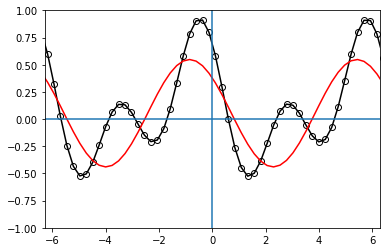

In [15]:
predictions = [quantum_model(weights_scale_1_3, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='red')
plt.ylim(-1,1)
plt.xlim(-np.pi*degree, np.pi*degree)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

### 1.3.3 Conclusion
When the variables ```degree = 2```, ```scale_target = 1``` and ```scale_train_model = 1```. The quantum model is untrainable!

## 2. Replication of FIG. 4.

From the article, the FIG. 4, is extracted and placed below.

<figure>
<img src="assets/images/FIG4.png" alt="Training of different models with different number of gates on 5-degree target model" width="625"/>
<figcaption><b>Figure 2 - Training of different models with different number of gates on 5-degree target model</b></figcaption>
</figure>

The figure caption is quoted below.

>FIG. 4. Fitting a truncated Fourier series of degree 5, $g(x) = \sum_{n=−5}^{5} c_n e^{2inx}$ with $c_n = 0.05−0.05i$ for $n = 1, . . . , 5$ and $c_0 = 0$, using a quantum model that repeats the encoding $r = 1, 3, 5$ times in sequence (left) and in parallel (right). Increasing r allows for closer and closer ﬁts until $r = 5$ ﬁts the data almost perfectly in both cases - illustrating that parallel and sequential repetitions of Pauli encodings extend the Fourier spectrum in the same manner. All models were trained with at most 200 steps of an Adam optimiser with learning rate 0.3 and batch size 25. For the “parallel” simulations, the W are not arbitrary unitaries but implemented by a smaller ansatz of three layers of parametrised rotations as well as entangling CNOT gates, as per Ref. [30], which is depicted by the hollow rounded gate symbols. The quantum model still easily ﬁtted the target function, which suggests that the results of this paper are of relevance for realistic quantum models.

##### Change the degree of the Fourier series to 5 for the target Function.

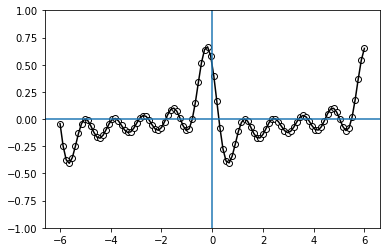

In [40]:
degree = 5

def target_function(x, degree):

    coeffs = [0.05 + 0.05j]*degree  # coefficients of non-zero frequencies
    coeff_0 = 0.0  # coefficient of zero frequency
    scale_target = 1.  # scale_target of the data

    res = 0.0 + 0.0j
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128((idx+1) * 1j * scale_target * x)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res + coeff_0)

x = np.linspace(-6, 6, data_points, requires_grad=False)
target_y = np.array([target_function(x_, degree) for x_ in x], requires_grad=False)

plt.plot(x, target_y, color='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

## 2.1 The first row 
The degree of trainable model needs to be $1$ so, for $r = 1$, which means in the one qubit model the there must be only one encoding gate.

In [17]:
# Reinitialize the (seeded) random initial weights
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True)
cost_ = [cost(weights, x, target_y)]

#  Run the optimizer for scale_target = 1 and scale_train_model = 2
(weights_scale_2_1, cost_2_1)= optimizer_func(weights)


Cost at step  15: 0.04093037138646561
Cost at step  30: 0.02481595846300839
Cost at step  45: 0.01908677661876058
Cost at step  60: 0.02059208837582719
Cost at step  75: 0.017757664832885576
Cost at step  90: 0.017665083914664155
Cost at step 105: 0.019347727128776658
Cost at step 120: 0.020007812308154353


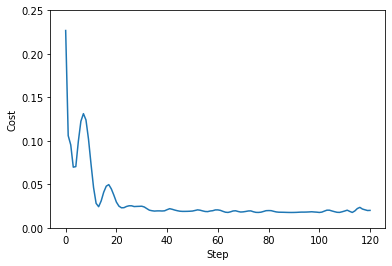

In [41]:
plt.plot(range(len(cost_2_1)), cost_2_1)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()

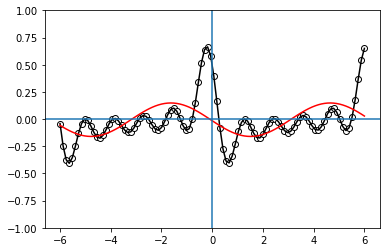

In [39]:
predictions = [quantum_model(weights_scale_2_1, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='red')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

## 2.2 Second row 
The degree of trainable model needs to be $3$ so, for $r = 3$, which means in the one qubit model the there must be three encoding gate.

In [20]:
# Reinitialize the (seeded) random initial weights
weights = 2 * np.pi * np.random.random(size=(4, 3), requires_grad=True)
cost_ = [cost(weights, x, target_y)]

#  Run the optimizer for scale_target = 1 and scale_train_model = 2
(weights_scale_2_2, cost_2_2)= optimizer_func(weights)


Cost at step  15: 0.1064905995699315
Cost at step  30: 0.02080953540131423
Cost at step  45: 0.015572902163001714
Cost at step  60: 0.015916937396241487
Cost at step  75: 0.015267646625025593
Cost at step  90: 0.013129814060830358
Cost at step 105: 0.011374291013430153
Cost at step 120: 0.01473476858681759


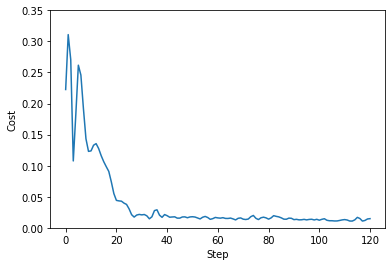

In [47]:
plt.plot(range(len(cost_2_2)), cost_2_2)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.35)
plt.show()

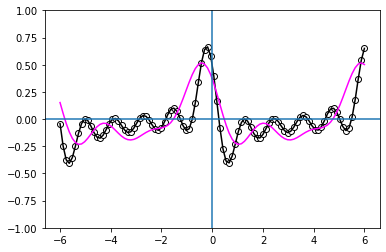

In [32]:
predictions = [quantum_model(weights_scale_2_2, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='magenta')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()

## 2.3 Third row
The degree of trainable model needs to be $5$ so, for $r = 5$, which means in the one qubit model the there must be five encoding gate.

In [23]:
# Reinitialize the (seeded) random initial weights
weights = 2 * np.pi * np.random.random(size=(6, 3), requires_grad=True)
cost_ = [cost(weights, x, target_y)]

#  Run the optimizer for scale_target = 1 and scale_train_model = 2
(weights_scale_2_3, cost_2_3)= optimizer_func(weights)


Cost at step  15: 0.0969286888563271
Cost at step  30: 0.023553028313278723
Cost at step  45: 0.018060875979088818
Cost at step  60: 0.017799797617805757
Cost at step  75: 0.004606241211557073
Cost at step  90: 0.001553828093141821
Cost at step 105: 0.0007904870684474747
Cost at step 120: 0.00047772941075562616


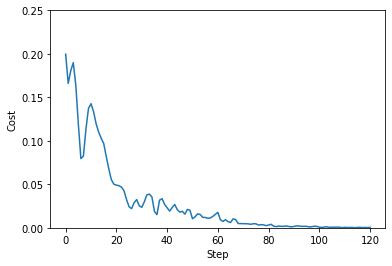

In [43]:
plt.plot(range(len(cost_2_3)), cost_2_3)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.25)
plt.show()

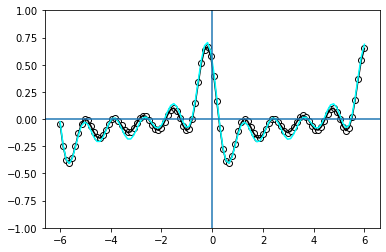

In [31]:
predictions = [quantum_model(weights_scale_2_3, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='cyan')
plt.ylim(-1, 1)
plt.axvline(0.0)
plt.axhline(0.0)
plt.show()